# Final Model

# Import

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import LSTM

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

import codebase

In [37]:
df = pd.read_csv('train.csv')
df = df.loc[(df.time < '2021-08-02')]
df = codebase.missing_data_alpha3(df)
df

,time,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm),elevation,city
0,2018-01-01,29.9,26.0,36.3,31.6,2018-01-01T05:15,2018-01-01T17:49,17.59,7.7,0.0,6.9,20.2,277.0,3.61,0,su
1,2018-01-02,30.6,25.7,37.7,31.2,2018-01-02T05:15,2018-01-02T17:50,19.87,9.4,0.0,7.1,18.0,168.0,4.11,0,su
2,2018-01-03,31.8,25.9,40.3,31.7,2018-01-03T05:16,2018-01-03T17:50,20.44,7.8,0.0,8.1,21.2,125.0,4.23,0,su
3,2018-01-04,30.8,26.0,39.1,31.6,2018-01-04T05:16,2018-01-04T17:50,20.44,29.7,0.0,7.2,21.6,190.0,4.22,0,su
4,2018-01-05,30.9,25.2,37.6,29.9,2018-01-05T05:17,2018-01-05T17:51,20.10,22.5,0.0,6.9,21.2,241.0,4.16,0,su
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13245,2021-07-28,9.3,5.4,5.1,1.8,1970-01-01T07:00,1970-01-01T07:00,13.87,5.0,0.0,20.2,30.2,54.0,1.74,0,q
13246,2021-07-29,9.5,6.9,5.2,3.0,1970-01-01T07:00,1970-01-01T07:00,8.00,0.4,0.0,21.8,32.8,67.0,1.66,0,q
13247,2021-07-30,6.8,5.0,3.0,1.1,1970-01-01T07:00,1970-01-01T07:00,8.14,2.8,0.0,16.1,25.6,54.0,1.26,0,q
13248,2021-07-31,6.0,3.7,2.9,0.7,1970-01-01T07:00,1970-01-01T07:00,9.30,2.1,0.0,16.1,21.2,352.0,1.20,0,q


In [38]:
columns_sum_used = ["shortwave_radiation (W/m²)", "direct_radiation (W/m²)", "diffuse_radiation (W/m²)", "direct_normal_irradiance (W/m²)"]
columns_mean_used = ['temperature_2m (°C)', 'relativehumidity_2m (%)', 'dewpoint_2m (°C)', 'pressure_msl (hPa)', 'surface_pressure (hPa)', 'cloudcover (%)', 
                'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)', "soil_temperature_0_to_7cm (°C)", "soil_temperature_7_to_28cm (°C)", 
                "soil_temperature_28_to_100cm (°C)",	"soil_temperature_100_to_255cm (°C)", "soil_moisture_0_to_7cm (m³/m³)", 
                "soil_moisture_7_to_28cm (m³/m³)", "soil_moisture_28_to_100cm (m³/m³)", "soil_moisture_100_to_255cm (m³/m³)"]

In [39]:
df_h_mean = pd.read_csv("train_hourly_mean.csv")
# df_h_mean = df_h_mean.loc[:, columns_mean_used + ["time", "city"]]
df_h_mean

,time,city,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,et0_fao_evapotranspiration (mm),vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2018-01-01,b,17.825000,98.708333,17.587500,21.050000,1011.916667,878.941667,0.000000,92.125000,...,0.046667,0.029583,18.637500,18.925000,19.479167,19.887500,0.425500,0.426708,0.399458,0.432042
1,2018-01-01,le,27.887500,84.416667,24.854167,34.670833,1007.008333,989.833333,0.000000,37.750000,...,0.205417,0.655417,24.850000,24.445833,24.100000,24.200000,0.418417,0.426208,0.401542,0.446000
2,2018-01-01,lh,24.591667,91.208333,23.029167,30.945833,1008.841667,1010.541667,0.000000,91.500000,...,0.092500,0.284167,24.945833,25.395833,25.800000,26.300000,0.450083,0.444917,0.442000,0.446000
3,2018-01-01,p,27.004167,84.750000,24.179167,32.583333,1006.820833,1006.320833,0.000000,67.416667,...,0.130417,0.560000,27.737500,27.270833,27.300000,27.100000,0.398958,0.403083,0.386292,0.390708
4,2018-01-01,q,-21.616667,64.916667,-26.445833,-24.341667,1011.504167,972.404167,0.023333,91.000000,...,0.001667,0.037917,-13.033333,-12.725000,-11.470833,-8.829167,0.334000,0.324000,0.267000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13253,2022-12-28,sa,-2.857143,97.714286,-3.157143,-3.042857,1020.185714,1015.485714,0.020000,90.714286,...,0.001429,0.011429,-0.100000,0.300000,2.600000,8.900000,0.375286,0.381286,0.394000,0.396000
13254,2022-12-28,si,25.428571,89.857143,23.642857,32.771429,1010.414286,987.242857,0.000000,40.857143,...,0.004286,0.328571,24.085714,25.057143,25.900000,26.300000,0.291143,0.299286,0.319286,0.311000
13255,2022-12-28,su,24.428571,91.571429,22.957143,30.371429,1009.700000,1012.000000,0.000000,38.142857,...,0.011429,0.261429,24.971429,26.271429,28.000000,28.800000,0.281000,0.286714,0.275000,0.298000
13256,2022-12-28,t,13.442857,87.000000,11.342857,13.485714,1016.214286,744.357143,0.000000,100.000000,...,0.028571,0.198571,14.728571,15.671429,16.300000,16.300000,0.348571,0.358571,0.344571,0.345000


In [40]:
df_h_median = pd.read_csv("train_hourly_median.csv")
df_h_median = df_h_median.loc[:, columns_sum_used + ["time", "city"]]
df_h_median

,shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),time,city
0,2.5,0.0,2.5,0.15,2018-01-01,b
1,26.5,13.0,13.5,91.00,2018-01-01,le
2,3.5,0.0,3.5,7.50,2018-01-01,lh
3,9.0,0.5,8.5,0.90,2018-01-01,p
4,0.0,0.0,0.0,0.00,2018-01-01,q
...,...,...,...,...,...,...
13253,0.0,0.0,0.0,0.00,2022-12-28,sa
13254,0.0,0.0,0.0,0.00,2022-12-28,si
13255,0.0,0.0,0.0,0.00,2022-12-28,su
13256,0.0,0.0,0.0,0.00,2022-12-28,t


In [41]:
df_h_windir = pd.read_csv('train_hourly_winddir.csv')
df_h_windir

,time,city,winddirection_10m (°)_sin,winddirection_100m (°)_sin,winddirection_10m (°)_cos,winddirection_100m (°)_cos
0,2018-01-01,b,0.388052,0.362438,-0.921638,-0.932008
1,2018-01-01,le,-0.882606,-0.916188,-0.470114,-0.400749
2,2018-01-01,lh,0.753276,0.747508,-0.657704,-0.664252
3,2018-01-01,p,0.368530,0.746541,-0.929616,-0.665339
4,2018-01-01,q,0.916479,0.996382,-0.400082,0.084982
...,...,...,...,...,...,...
13253,2022-12-28,sa,-0.190809,-0.239502,-0.981627,-0.970896
13254,2022-12-28,si,-0.316122,-0.301895,-0.948718,-0.953341
13255,2022-12-28,su,-0.995276,-0.996819,0.097087,0.079702
13256,2022-12-28,t,-0.039883,-0.124344,0.999204,0.992239


In [42]:
df_h_max = pd.read_csv('train_hourly_max.csv')
df_h_max = df_h_max.loc[:, ['time', 'city', 'relativehumidity_2m (%)']].rename({'relativehumidity_2m (%)':'relativehumidity_2m (%)_max'}, axis=1)
df_h_max

,time,city,relativehumidity_2m (%)_max
0,2018-01-01,b,100.0
1,2018-01-01,le,97.0
2,2018-01-01,lh,98.0
3,2018-01-01,p,92.0
4,2018-01-01,q,72.0
...,...,...,...
13253,2022-12-28,sa,99.0
13254,2022-12-28,si,92.0
13255,2022-12-28,su,92.0
13256,2022-12-28,t,90.0


In [43]:
df_h_min = pd.read_csv('train_hourly_min.csv')
df_h_min = df_h_min.loc[:, ['time', 'city', 'relativehumidity_2m (%)']].rename({'relativehumidity_2m (%)':'relativehumidity_2m (%)_min'}, axis=1)
df_h_min

,time,city,relativehumidity_2m (%)_min
0,2018-01-01,b,94.0
1,2018-01-01,le,67.0
2,2018-01-01,lh,82.0
3,2018-01-01,p,73.0
4,2018-01-01,q,59.0
...,...,...,...
13253,2022-12-28,sa,96.0
13254,2022-12-28,si,88.0
13255,2022-12-28,su,91.0
13256,2022-12-28,t,80.0


In [44]:
h_mean_intersection = set(df.columns).union(set(df_h_median.columns)).union(set(df_h_windir.columns)).intersection(df_h_mean.columns).union({'winddirection_10m (°)', 'winddirection_100m (°)'})
h_mean_cols = df_h_mean.columns.difference(h_mean_intersection).union({'time', 'city'})
df_h_mean = df_h_mean.loc[:, h_mean_cols]

# Preprocessing

In [45]:
df_merged = df.merge(df_h_mean, left_on=['time', 'city'], right_on=['time', 'city'], how='inner'
                    ).merge(df_h_median, left_on=['time', 'city'], right_on=['time', 'city'], how='inner'
                    ).merge(df_h_windir, left_on=['time', 'city'], right_on=['time', 'city'], how='inner')
print(df_merged.columns)
df_merged

Index(['time', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'apparent_temperature_max (°C)', 'apparent_temperature_min (°C)',
       'sunrise (iso8601)', 'sunset (iso8601)',
       'shortwave_radiation_sum (MJ/m²)', 'rain_sum (mm)', 'snowfall_sum (cm)',
       'windspeed_10m_max (km/h)', 'windgusts_10m_max (km/h)',
       'winddirection_10m_dominant (°)', 'et0_fao_evapotranspiration (mm)',
       'elevation', 'city', 'apparent_temperature (°C)', 'cloudcover (%)',
       'cloudcover_high (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)',
       'dewpoint_2m (°C)', 'pressure_msl (hPa)', 'relativehumidity_2m (%)',
       'snowfall (cm)', 'soil_moisture_0_to_7cm (m³/m³)',
       'soil_moisture_100_to_255cm (m³/m³)',
       'soil_moisture_28_to_100cm (m³/m³)', 'soil_moisture_7_to_28cm (m³/m³)',
       'soil_temperature_0_to_7cm (°C)', 'soil_temperature_100_to_255cm (°C)',
       'soil_temperature_28_to_100cm (°C)', 'soil_temperature_7_to_28cm (°C)',
       'surface_pressure (

,time,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),...,windspeed_100m (km/h),windspeed_10m (km/h),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),winddirection_10m (°)_sin,winddirection_100m (°)_sin,winddirection_10m (°)_cos,winddirection_100m (°)_cos
0,2018-01-01,29.9,26.0,36.3,31.6,2018-01-01T05:15,2018-01-01T17:49,17.59,7.7,0.0,...,3.833333,3.125000,22.0,6.5,15.5,54.75,-0.969410,-0.968148,-0.245448,-0.250380
1,2018-01-02,30.6,25.7,37.7,31.2,2018-01-02T05:15,2018-01-02T17:50,19.87,9.4,0.0,...,5.312500,4.120833,19.5,4.0,15.5,43.10,0.142773,0.192237,-0.989755,-0.981349
2,2018-01-03,31.8,25.9,40.3,31.7,2018-01-03T05:16,2018-01-03T17:50,20.44,7.8,0.0,...,6.095833,4.566667,21.5,6.0,15.5,11.60,0.714778,0.766512,-0.699352,-0.642230
3,2018-01-04,30.8,26.0,39.1,31.6,2018-01-04T05:16,2018-01-04T17:50,20.44,29.7,0.0,...,5.291667,4.233333,20.5,5.0,15.5,28.05,-0.375281,-0.321439,-0.926911,-0.946930
4,2018-01-05,30.9,25.2,37.6,29.9,2018-01-05T05:17,2018-01-05T17:51,20.10,22.5,0.0,...,5.975000,4.637500,19.0,3.0,16.0,15.35,0.107421,-0.195804,-0.994214,-0.980643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13085,2021-07-28,9.3,5.4,5.1,1.8,1970-01-01T07:00,1970-01-01T07:00,13.87,5.0,0.0,...,17.450000,14.558333,155.5,31.0,82.0,113.25,0.804721,0.975821,0.593653,0.218569
13086,2021-07-29,9.5,6.9,5.2,3.0,1970-01-01T07:00,1970-01-01T07:00,8.00,0.4,0.0,...,23.908333,17.175000,87.0,16.5,70.0,80.45,0.916479,0.996860,0.400082,-0.079184
13087,2021-07-30,6.8,5.0,3.0,1.1,1970-01-01T07:00,1970-01-01T07:00,8.14,2.8,0.0,...,15.758333,13.937500,97.5,15.0,82.0,66.15,0.826180,0.970296,0.563406,0.241922
13088,2021-07-31,6.0,3.7,2.9,0.7,1970-01-01T07:00,1970-01-01T07:00,9.30,2.1,0.0,...,8.745833,9.350000,88.5,6.5,75.0,19.35,-0.971687,0.959642,-0.236273,-0.281225


Making features more useful by transforming it with another feature

In [46]:
def feature_eng(data):
    data = data.copy()
    # data = data.drop('winddirection_10m_dominant (°)', axis=1)
    data['combo1'] = data['relativehumidity_2m (%)'] * data['cloudcover_mid (%)']
    data['combo2'] = data['relativehumidity_2m (%)'] * data['shortwave_radiation_sum (MJ/m²)']
    # data['combo3'] = data['soil_moisture_0_to_7cm (m³/m³)'] * data['apparent_temperature (°C)']
    # data['combo4'] = data['temperature_2m (°C)'] - (0.33 * data['windspeed_10m (km/h)'])
    data['humidxdew'] = data['relativehumidity_2m (%)'] * data['dewpoint_2m (°C)']
    # data['moist_avec'] = data['relativehumidity_2m (%)'] + ((data['temperature_2m (°C)'] + data['pressure_msl (hPa)'])/(1 - (data['vapor_pressure_deficit (kPa)']/data['pressure_msl (hPa)'])))
    data['windrxhumid'] = data['relativehumidity_2m (%)'] * data['winddirection_10m (°)_cos'] * data['winddirection_10m (°)_sin']
    data['windrxdew'] = data['dewpoint_2m (°C)'] * data['winddirection_10m (°)_cos'] *  data['winddirection_10m (°)_sin']
    data['combo3'] = data['soil_moisture_0_to_7cm (m³/m³)'] * data['diffuse_radiation (W/m²)'] * data['relativehumidity_2m (%)']
    return data

Final preprocessing steps, the data is not randomly divided into train and test data because it's a time series data. The data is then scaled because SVM is sensitive to feature scaling

In [47]:
df_merged = codebase.preprocessing_alpha5(data=df_merged)

# df_merged_copy = df_merged.copy()
# df_merged_copy_drop = df_merged_copy.drop('rain_sum (mm)', axis=1)
# df_merged_copy_drop['rain_sum (mm)'] = df_merged_copy.loc[:, 'rain_sum (mm)'].shift(periods=-1)
# df_merged = df_merged_copy_drop
# df_merged = df_merged.drop('2021-08-01')

df_merged = feature_eng(df_merged)

X = df_merged.drop('rain_sum (mm)', axis=1)
y = df_merged['rain_sum (mm)']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8, shuffle=False)

# rfecv_support_ = ["temperature_2m_max (°C)", "apparent_temperature_max (°C)", "cloudcover (%)", "cloudcover_low (%)", 
#                 "cloudcover_mid (%)", "cloudcover_high (%)"]

# Train test split based on time
train = df_merged[df_merged.index < '2020-07-04']
test = df_merged[(df_merged.index >= '2020-07-04')]

X_train, y_train = train.drop('rain_sum (mm)', axis=1), train['rain_sum (mm)']
X_test, y_test = test.drop('rain_sum (mm)', axis=1), test['rain_sum (mm)']

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X = ss.transform(X)

In [48]:
print(X_train.shape)
print(X_test.shape)

(9150, 63)
(3940, 63)


In [15]:
df_merged

,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),...,city_6,city_7,city_8,city_9,combo1,combo2,humidxdew,windrxhumid,windrxdew,combo3
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01,29.9,26.0,36.3,31.6,17.59,7.7,0.0,6.9,20.2,277.0,...,0.0,1.0,0.0,0.0,2526.625000,1530.330000,2093.075000,20.700783,5.724441,401.740625
2018-01-02,30.6,25.7,37.7,31.2,19.87,9.4,0.0,7.1,18.0,168.0,...,0.0,1.0,0.0,0.0,1513.546875,1706.336250,2047.045312,-12.135018,-3.368483,420.227523
2018-01-03,31.8,25.9,40.3,31.7,20.44,7.8,0.0,8.1,21.2,125.0,...,0.0,1.0,0.0,0.0,1711.500000,1716.960000,2028.600000,-41.990005,-12.072126,389.189500
2018-01-04,30.8,26.0,39.1,31.6,20.44,29.7,0.0,7.2,21.6,190.0,...,0.0,1.0,0.0,0.0,2067.892361,1776.576667,2097.226736,30.234131,8.393377,433.688816
2018-01-05,30.9,25.2,37.6,29.9,20.10,22.5,0.0,6.9,21.2,241.0,...,0.0,1.0,0.0,0.0,1125.201389,1717.712500,2043.522396,-9.126898,-2.553840,445.010028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-28,9.3,5.4,5.1,1.8,13.87,5.0,0.0,20.2,30.2,54.0,...,0.0,0.0,0.0,0.0,2790.833333,943.160000,335.750000,32.485308,2.358768,681.433667
2021-07-29,9.5,6.9,5.2,3.0,8.00,0.4,0.0,21.8,32.8,67.0,...,0.0,0.0,0.0,0.0,5385.378472,519.333333,327.558681,23.802814,1.850142,713.055486
2021-07-30,6.8,5.0,3.0,1.1,8.14,2.8,0.0,16.1,25.6,54.0,...,0.0,0.0,0.0,0.0,4778.281250,587.097500,218.478646,33.572371,1.410001,916.955177


# CV

In [ ]:
# mses = []
# tscv = TimeSeriesSplit(n_splits=3, test_size=4000)
# for train_index, test_index in tscv.split(X):
#     print(train_index, test_index)
#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     ss = StandardScaler()
#     X_train = ss.fit_transform(X_train)
#     X_test = ss.transform(X_test)
    
#     svr = SVR(C=100, degree=1, gamma=0.01)
#     svr.fit(X_train, y_train)
#     y_pred_svr100 = svr.predict(X_test)
#     mses.append(mean_squared_error(y_test, y_pred_svr100))

# print(mses)
# print("Average MSE  :", np.average(mses))
# print("Average RMSE :", np.sqrt(np.average(mses)))

# Train Eval

Evaluating model all at once

In [ ]:
def train_eval_models(models: dict, X_train, X_test, y_train, y_test):
    for model in models:
        m = model
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)
        print(model.__class__.__name__, models[model])
        codebase.metrics(y_test, y_pred)

In [ ]:
models = {
    SGDRegressor(): '',
    SVR(): '', 
    SVR(C=100, degree=1, gamma=0.01): '(C=100, degree=1, gamma=0.01)',
    SVR(C=200, degree=1, gamma=0.01): '(C=200, degree=1, gamma=0.01)'
    }
train_eval_models(models, X_train, X_test, y_train, y_test)

SGDRegressor 
MSE  : 34.5318322472434
RMSE : 5.8763791783072845
SVR 
MSE  : 33.05279926029823
RMSE : 5.74915639553302
SVR (C=100, degree=1, gamma=0.01)
MSE  : 24.658874675578605
RMSE : 4.965770300323869
SVR (C=200, degree=1, gamma=0.01)
MSE  : 23.430617858880417
RMSE : 4.840518346094808


In [ ]:
models = {
    SGDRegressor(): '',
    SVR(): '', 
    SVR(C=100, degree=1, gamma=0.01): '(C=100, degree=1, gamma=0.01)',
    SVR(C=200, degree=1, gamma=0.01): '(C=200, degree=1, gamma=0.01)'
    }
train_eval_models(models, X_train, X_test, y_train, y_test)

SGDRegressor 
MSE  : 35.568942339520184
RMSE : 5.963970350322022
SVR 
MSE  : 34.067524183608924
RMSE : 5.836739173854604
SVR (C=100, degree=1, gamma=0.01)
MSE  : 25.595307202646747
RMSE : 5.059180487257471
SVR (C=200, degree=1, gamma=0.01)
MSE  : 24.329876609745227
RMSE : 4.932532474271733


In [ ]:
models = {
    SGDRegressor(): '',
    SVR(): '', 
    SVR(C=100, degree=1, gamma=0.01): '(C=100, degree=1, gamma=0.01)',
    SVR(C=200, degree=1, gamma=0.01): '(C=200, degree=1, gamma=0.01)'
    }
train_eval_models(models, X_train, X_test, y_train, y_test)

SGDRegressor 
MSE  : 34.38809600030602
RMSE : 5.864136424087183
SVR 
MSE  : 33.27456734974623
RMSE : 5.768411163374732
SVR (C=100, degree=1, gamma=0.01)
MSE  : 24.50707566027586
RMSE : 4.950462166331126
SVR (C=200, degree=1, gamma=0.01)
MSE  : 23.217866336268045
RMSE : 4.818492122673653


# Train Eval LinReg

Baseline model

In [ ]:
sr = SGDRegressor()
sr.fit(X_train, y_train)

y_pred = sr.predict(X_test)
codebase.metrics(y_test, y_pred)

SGDRegressor()

Baseline model is 2 times worse than the leading model (11 Jan)

# Train Eval SVM

High regularization leads to better MSE

In [16]:
svr = SVR(C=100, degree=1, gamma=0.01)
svr.fit(X_train, y_train)
y_pred_svr100 = svr.predict(X_test)
codebase.metrics(y_test, y_pred_svr100)

MSE  : 22.588601066209282
RMSE : 4.752746686518153


In [97]:
svr = SVR(C=200, degree=1, gamma=0.01)
svr.fit(X_train, y_train)
y_pred_svr200 = svr.predict(X_test)
codebase.metrics(y_test, y_pred_svr200)

MSE  : 22.47547611792186
RMSE : 4.740830741328134


In [21]:
svr = SVR(C=500, degree=1, gamma=0.01)
svr.fit(X_train, y_train)
y_pred_svr500 = svr.predict(X_test)
codebase.metrics(y_test, y_pred_svr500)

MSE  : 21.32593934536461
RMSE : 4.618001661472699


In [17]:
svr = SVR(C=1000, degree=1, gamma=0.01)
svr.fit(X_train, y_train)
y_pred_svr1000 = svr.predict(X_test)
codebase.metrics(y_test, y_pred_svr1000)

MSE  : 20.783282288090216
RMSE : 4.5588685315646265


Soil moisture, apparent temperature, and max apparent temprature has a high importance using permutation importance function

In [24]:
perm_importance = permutation_importance(svr, X_test, y_test)

In [31]:
pd.DataFrame(np.c_[df_merged.drop('rain_sum (mm)', axis=1).columns, perm_importance['importances_mean']]).sort_values(1, ascending=False)

,0,1
20,soil_moisture_0_to_7cm (m³/m³),4.884502
11,apparent_temperature (°C),2.795874
2,apparent_temperature_max (°C),1.243906
27,soil_temperature_7_to_28cm (°C),0.938764
12,cloudcover (%),0.762151
1,temperature_2m_min (°C),0.720519
9,et0_fao_evapotranspiration (mm),0.604654
24,soil_temperature_0_to_7cm (°C),0.56277
23,soil_moisture_7_to_28cm (m³/m³),0.452385
14,cloudcover_low (%),0.40634


In [32]:
pd.DataFrame(np.c_[df_merged.drop('rain_sum (mm)', axis=1).columns, perm_importance['importances_std']]).sort_values(1, ascending=False)

,0,1
20,soil_moisture_0_to_7cm (m³/m³),0.144742
11,apparent_temperature (°C),0.057393
2,apparent_temperature_max (°C),0.025369
23,soil_moisture_7_to_28cm (m³/m³),0.021936
9,et0_fao_evapotranspiration (mm),0.017706
27,soil_temperature_7_to_28cm (°C),0.014791
12,cloudcover (%),0.014592
37,direct_normal_irradiance (W/m²),0.014205
14,cloudcover_low (%),0.013615
1,temperature_2m_min (°C),0.013007


## Hyperparam Tuning

In [69]:
# defining parameter range
param_grid = {'C': [1000, 2000, 10000],
			'gamma': [1, 0.01, 0.001],
			'degree': [1, 3, 10],
			'kernel': ['rbf']}

grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3, n_jobs=-1, scoring="neg_mean_squared_error")

# fitting the model for grid search
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
codebase.metrics(y_test, y_pred)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 4/5] END C=1000, degree=1, gamma=1, kernel=rbf;, score=-219.970 total time=   6.6s
[CV 3/5] END C=1000, degree=1, gamma=1, kernel=rbf;, score=-49.319 total time=   7.3s
[CV 5/5] END C=1000, degree=1, gamma=1, kernel=rbf;, score=-67.338 total time=   7.4s
[CV 2/5] END C=1000, degree=1, gamma=1, kernel=rbf;, score=-85.985 total time=   7.5s
[CV 1/5] END C=1000, degree=1, gamma=1, kernel=rbf;, score=-78.656 total time=   7.9s
[CV 1/5] END C=1000, degree=1, gamma=0.001, kernel=rbf;, score=-42.621 total time=  10.8s
[CV 2/5] END C=1000, degree=1, gamma=0.001, kernel=rbf;, score=-57.366 total time=  11.6s
[CV 3/5] END C=1000, degree=1, gamma=0.001, kernel=rbf;, score=-30.998 total time=  11.7s
[CV 5/5] END C=1000, degree=1, gamma=0.001, kernel=rbf;, score=-372.378 total time=   7.5s
[CV 1/5] END C=1000, degree=3, gamma=1, kernel=rbf;, score=-78.656 total time=   8.0s
[CV 4/5] END C=1000, degree=1, gamma=0.001, kernel=rbf;, sco

In [70]:
print(grid.best_estimator_)
y_pred = grid.predict(X_test)
codebase.metrics(y_test, y_pred)

SVR(C=1000, degree=1, gamma=0.01)
MSE  : 20.944193188740734
RMSE : 4.576482621920544


# Train Eval XGB

In [49]:
bst = XGBRegressor()
bst.fit(X_train, y_train)
y_pred_xgb = bst.predict(X_test)
codebase.metrics(y_test, y_pred_xgb)

MSE  : 25.434568059070404
RMSE : 5.043269580249543


In [33]:
pd.DataFrame(np.c_[df_merged.drop('rain_sum (mm)', axis=1).columns, bst.feature_importances_]).sort_values(1, ascending=False)[0:50]

,0,1
17,relativehumidity_2m (%),0.251942
58,combo2,0.083302
57,combo1,0.049532
20,soil_moisture_100_to_255cm (m³/m³),0.04726
59,humidxdew,0.044804
42,elevation_1,0.040378
19,soil_moisture_0_to_7cm (m³/m³),0.031292
62,combo3,0.030873
25,soil_temperature_28_to_100cm (°C),0.026216
44,elevation_3,0.022614


In [39]:
xgb_params = {'max_depth': [3, 10, 18],
        'gamma': [1, 5,  9],
        'reg_alpha' : [40, 80, 120, 180],
        'reg_lambda' : [0, 0.5,  1],
        'colsample_bytree' : [0.5, 0.75, 1],
        'min_child_weight' : [0, 5, 10],
        'n_estimators': [180],
        'seed': [0]}

clf = GridSearchCV(bst, xgb_params, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)
y_pred = clf.predict(X_test)
codebase.metrics(y_test, y_pred)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, min_child_weight=0, n_estimators=180, reg_alpha=40, reg_lambda=0, seed=0; total time=   1.7s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, min_child_weight=0, n_estimators=180, reg_alpha=40, reg_lambda=0.5, seed=0; total time=   1.7s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, min_child_weight=0, n_estimators=180, reg_alpha=40, reg_lambda=0, seed=0; total time=   1.8s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, min_child_weight=0, n_estimators=180, reg_alpha=40, reg_lambda=0, seed=0; total time=   1.7s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, min_child_weight=0, n_estimators=180, reg_alpha=40, reg_lambda=0, seed=0; total time=   1.8s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, min_child_weight=0, n_estimators=180, reg_alpha=40, reg_lambda=0, seed=0; total time=   1.9s
[CV] END colsample_bytree=0.5, gamma=1, max_depth=3, min_c

In [208]:
bst = XGBRegressor(colsample_bytree= 0.75, gamma= 1, max_depth= 10, min_child_weight= 5, n_estimators= 180, reg_alpha= 180, 
                    reg_lambda= 0, seed= 0)
bst.fit(X_train, y_train)
y_pred_xgb_gs = bst.predict(X_test)
codebase.metrics(y_test, y_pred)

MSE  : 26.63634914922229
RMSE : 5.161041479122435


In [74]:
bst = XGBRegressor(max_depth= 2, n_estimators= 20)
bst.fit(X_train, y_train)
y_pred = bst.predict(X_test)
codebase.metrics(y_test, y_pred)

MSE  : 29.73542885028299
RMSE : 5.453020158616965


# Train Eval LSTM

kurang timesteps di input

## Timestepped

In [ ]:
df_for_training_scaled = pd.DataFrame(X_train).join(y_train.reset_index().drop('time', axis=1))
df_for_training_scaled

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,rain_sum (mm)
0,0.515762,0.690984,0.569566,0.742382,0.048724,-0.171346,-0.795551,-0.899598,1.161968,0.176874,...,0.048655,-0.323475,1.067827,-0.368296,-1.563023,-1.561510,0.473976,0.447471,0.368536,7.7
1,0.568512,0.667180,0.651594,0.717673,0.399274,-0.171346,-0.762692,-1.144719,0.019421,0.523487,...,0.399018,0.003366,1.162098,-0.125272,0.035576,0.068647,-0.976643,-1.018658,0.373667,9.4
2,0.658942,0.683050,0.803933,0.748559,0.486911,-0.171346,-0.598398,-0.788179,-0.431308,0.606674,...,0.487577,0.327364,0.495705,0.103319,0.857750,0.875413,-0.410659,-0.338477,0.368536,7.8
3,0.583584,0.690984,0.733623,0.742382,0.486911,-0.171346,-0.746263,-0.743612,0.250027,0.599742,...,0.487023,0.404101,0.274657,0.161376,-0.709050,-0.652987,-0.854162,-0.949624,0.368536,29.7
4,0.591120,0.627507,0.645735,0.637371,0.434636,-0.171346,-0.795551,-0.788179,0.784613,0.558148,...,0.433888,0.193218,0.721628,-0.054078,-0.015237,-0.476488,-0.985332,-1.017243,0.368536,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8935,-1.262688,-0.959426,-1.416695,-1.178698,2.191996,-0.171346,0.798105,-0.264511,-1.280357,-0.003365,...,2.192343,2.403797,-0.435620,4.884440,0.824310,1.080723,2.360196,1.769469,-3.500270,0.0
8936,-1.157187,-1.070512,-1.276075,-1.153990,1.377122,-0.171346,0.502375,-0.821605,-1.343249,-0.502488,...,1.377044,0.763910,1.859372,1.697446,0.535417,1.038988,-0.746028,1.891303,-3.500270,0.0
8937,-1.262688,-1.054642,-1.346385,-1.153990,1.904484,-0.171346,-0.483391,-1.668388,1.969088,-0.363843,...,1.904525,1.869483,0.247026,4.164330,-1.478008,-0.342163,1.759270,-1.045976,-3.500270,0.0
8938,-1.194866,-1.086381,-1.276075,-1.184875,1.884497,-0.171346,-0.713404,-1.824374,-1.573855,-0.183604,...,1.884600,1.955315,-0.056914,4.231529,1.237169,0.536964,0.552680,-0.756681,-3.500270,0.0


In [ ]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 7  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled.iloc[i - n_past:i, 0:-1])
    trainY.append(df_for_training_scaled.iloc[i + n_future - 1:i + n_future, -1])

trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (8933, 7, 37).
trainY shape == (8933, 1).


In [76]:
model = Sequential()
model.add(LSTM(units = 128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))

model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 64))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(trainX, trainY, epochs = 20, batch_size = 20, validation_split=.20)

NameError: name 'trainX' is not defined

In [ ]:
testX = []
testY = []

tests = pd.DataFrame(X_test).join(y_test.reset_index().drop('time', axis=1))

for i in range(n_past, len(tests) - n_future +1):
    testX.append(tests.iloc[i - n_past:i, 0:-1])
    testY.append(tests.iloc[i + n_future - 1:i + n_future, -1])

testX, testY = np.array(testX), np.array(testY)
y_pred = model.predict(testX)
codebase.metrics(testY, y_pred)

## Reshaped

In [50]:
print(X_train.shape)
X_train_s = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train_s = np.array(y_train)
X_test_s = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test_s = np.array(y_test)

(9150, 63)


## 100

2023-01-21 18:36:27.277890: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/16
458/458 [==============================] - 3s 3ms/step - loss: 53.0690 - val_loss: 33.2532
Epoch 2/16
458/458 [==============================] - 1s 3ms/step - loss: 36.4075 - val_loss: 29.7211
Epoch 3/16
458/458 [==============================] - 1s 3ms/step - loss: 33.3969 - val_loss: 28.3151
Epoch 4/16
458/458 [==============================] - 1s 3ms/step - loss: 31.3489 - val_loss: 27.0646
Epoch 5/16
458/458 [==============================] - 1s 3ms/step - loss: 30.2221 - val_loss: 26.8262
Epoch 6/16
458/458 [==============================] - 1s 3ms/step - loss: 29.3590 - val_loss: 28.0454
Epoch 7/16
458/458 [==============================] - 1s 3ms/step - loss: 27.9861 - val_loss: 26.4848
Epoch 8/16
458/458 [==============================] - 1s 3ms/step - loss: 27.4692 - val_loss: 27.5230
Epoch 9/16
458/458 [==============================] - 1s 3ms/step - loss: 26.7454 - val_loss: 24.7719
Epoch 10/16
458/458 [==============================] - 1s 3ms/step - loss: 25.4437

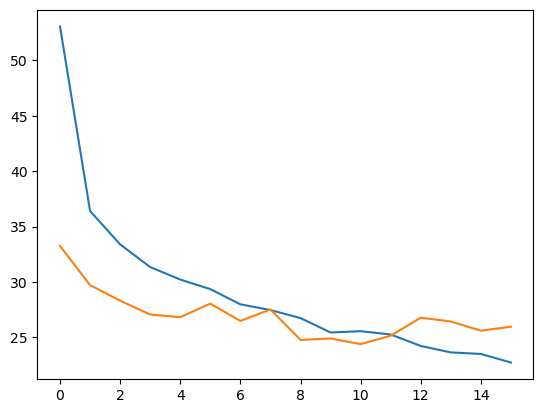

In [51]:
model = Sequential()
model.add(LSTM(units = 100, return_sequences = True))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train_s, y_train_s, epochs = 16, batch_size = 20, validation_data=(X_test_s, y_test_s))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
y_pred_lstm = model.predict(X_test_s)
codebase.metrics(y_test, y_pred_lstm.reshape((X_test.shape[0],)))

Epoch 1/18
458/458 [==============================] - 5s 4ms/step - loss: 48.7728 - val_loss: 34.8062
Epoch 2/18
458/458 [==============================] - 2s 4ms/step - loss: 35.5303 - val_loss: 30.4813
Epoch 3/18
458/458 [==============================] - 2s 4ms/step - loss: 33.1389 - val_loss: 28.3779
Epoch 4/18
458/458 [==============================] - 2s 4ms/step - loss: 31.1221 - val_loss: 29.8024
Epoch 5/18
458/458 [==============================] - 2s 4ms/step - loss: 30.1585 - val_loss: 28.3406
Epoch 6/18
458/458 [==============================] - 2s 4ms/step - loss: 28.9619 - val_loss: 26.9101
Epoch 7/18
458/458 [==============================] - 2s 4ms/step - loss: 27.5758 - val_loss: 25.9243
Epoch 8/18
458/458 [==============================] - 2s 4ms/step - loss: 26.3561 - val_loss: 26.0568
Epoch 9/18
458/458 [==============================] - 2s 4ms/step - loss: 26.3670 - val_loss: 24.9991
Epoch 10/18
458/458 [==============================] - 2s 4ms/step - loss: 25.8820

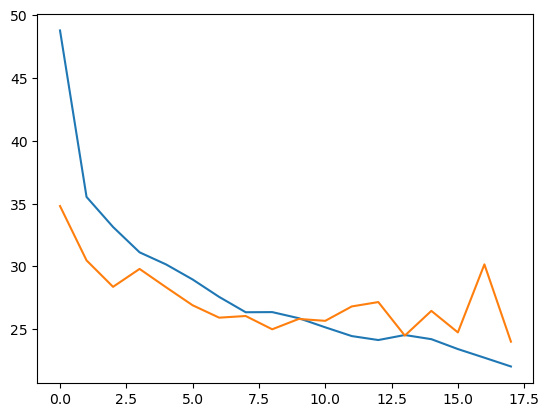

In [26]:
model = Sequential()
model.add(LSTM(units = 100, return_sequences = True))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train_s, y_train_s, epochs = 18, batch_size = 20, validation_data=(X_test_s, y_test_s))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
y_pred_lstm = model.predict(X_test_s)
codebase.metrics(y_test, y_pred_lstm.reshape((X_test.shape[0],)))

Epoch 1/16
458/458 [==============================] - 5s 4ms/step - loss: 49.5550 - val_loss: 33.3265
Epoch 2/16
458/458 [==============================] - 2s 4ms/step - loss: 35.9354 - val_loss: 30.5640
Epoch 3/16
458/458 [==============================] - 2s 4ms/step - loss: 33.6054 - val_loss: 30.0770
Epoch 4/16
458/458 [==============================] - 2s 4ms/step - loss: 31.7314 - val_loss: 28.2029
Epoch 5/16
458/458 [==============================] - 2s 4ms/step - loss: 30.7938 - val_loss: 27.7391
Epoch 6/16
458/458 [==============================] - 2s 4ms/step - loss: 29.8831 - val_loss: 28.9916
Epoch 7/16
458/458 [==============================] - 2s 4ms/step - loss: 28.7077 - val_loss: 26.3313
Epoch 8/16
458/458 [==============================] - 2s 4ms/step - loss: 28.2054 - val_loss: 26.8264
Epoch 9/16
458/458 [==============================] - 2s 4ms/step - loss: 26.8095 - val_loss: 26.9193
Epoch 10/16
458/458 [==============================] - 2s 4ms/step - loss: 26.5273

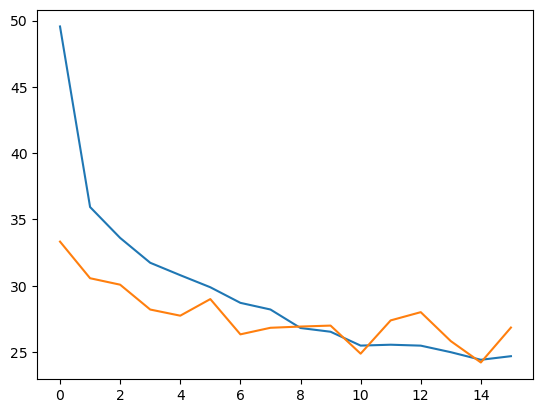

In [27]:
model = Sequential()
model.add(LSTM(units = 100, return_sequences = True))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train_s, y_train_s, epochs = 16, batch_size = 20, validation_data=(X_test_s, y_test_s))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
y_pred_lstm = model.predict(X_test_s)
codebase.metrics(y_test, y_pred_lstm.reshape((X_test.shape[0],)))

## 128

Epoch 1/16
458/458 [==============================] - 4s 4ms/step - loss: 46.9993 - val_loss: 31.5883
Epoch 2/16
458/458 [==============================] - 2s 4ms/step - loss: 34.8479 - val_loss: 29.2904
Epoch 3/16
458/458 [==============================] - 2s 3ms/step - loss: 32.4211 - val_loss: 30.0419
Epoch 4/16
458/458 [==============================] - 2s 3ms/step - loss: 30.6740 - val_loss: 28.2758
Epoch 5/16
458/458 [==============================] - 2s 3ms/step - loss: 29.6919 - val_loss: 26.3341
Epoch 6/16
458/458 [==============================] - 2s 4ms/step - loss: 28.1906 - val_loss: 25.8662
Epoch 7/16
458/458 [==============================] - 2s 3ms/step - loss: 27.2635 - val_loss: 25.1612
Epoch 8/16
458/458 [==============================] - 2s 3ms/step - loss: 26.4456 - val_loss: 25.5480
Epoch 9/16
458/458 [==============================] - 2s 4ms/step - loss: 25.5506 - val_loss: 26.1932
Epoch 10/16
458/458 [==============================] - 2s 3ms/step - loss: 25.4400

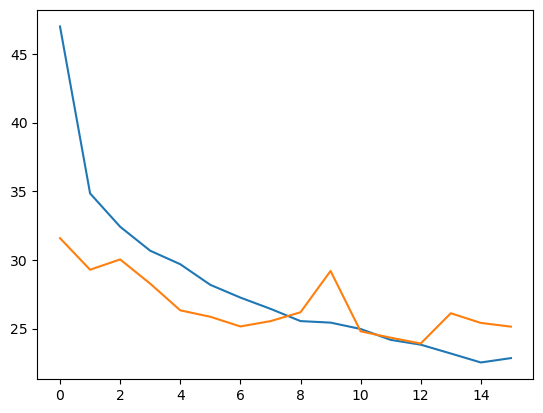

In [29]:
model = Sequential()
model.add(LSTM(units = 128, return_sequences = True))

model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train_s, y_train_s, epochs = 16, batch_size = 20, validation_data=(X_test_s, y_test_s), workers=8)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
y_pred_lstm = model.predict(X_test_s)
codebase.metrics(y_test, y_pred_lstm.reshape((X_test.shape[0],)))

Epoch 1/20
458/458 [==============================] - 5s 5ms/step - loss: 49.2843 - val_loss: 31.8984
Epoch 2/20
458/458 [==============================] - 3s 6ms/step - loss: 35.5647 - val_loss: 30.5003
Epoch 3/20
458/458 [==============================] - 3s 6ms/step - loss: 33.1886 - val_loss: 30.3573
Epoch 4/20
458/458 [==============================] - 3s 6ms/step - loss: 31.6425 - val_loss: 28.9078
Epoch 5/20
458/458 [==============================] - 2s 5ms/step - loss: 30.2137 - val_loss: 30.1781
Epoch 6/20
458/458 [==============================] - 3s 6ms/step - loss: 29.1559 - val_loss: 27.4127
Epoch 7/20
458/458 [==============================] - 2s 5ms/step - loss: 27.9642 - val_loss: 27.4183
Epoch 8/20
458/458 [==============================] - 2s 5ms/step - loss: 27.9611 - val_loss: 25.6208
Epoch 9/20
458/458 [==============================] - 2s 5ms/step - loss: 27.0219 - val_loss: 24.8137
Epoch 10/20
458/458 [==============================] - 2s 5ms/step - loss: 26.1384

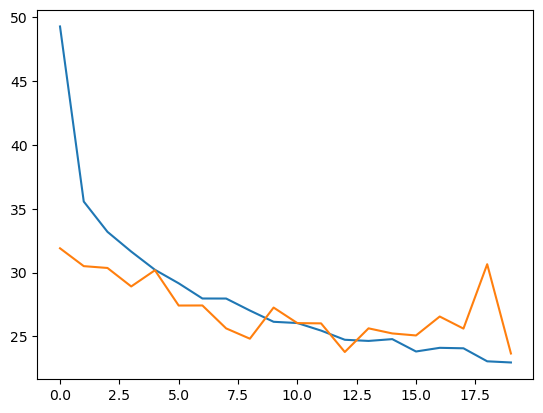

In [31]:
model = Sequential()
model.add(LSTM(units = 128, return_sequences = True))

model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train_s, y_train_s, epochs = 20, batch_size = 20, validation_data=(X_test_s, y_test_s), workers=8)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
y_pred_lstm = model.predict(X_test_s)
codebase.metrics(y_test, y_pred_lstm.reshape((X_test.shape[0],)))

Epoch 1/40
286/286 [==============================] - 9s 19ms/step - loss: 47.8898 - val_loss: 31.8964
Epoch 2/40
286/286 [==============================] - 6s 21ms/step - loss: 35.1879 - val_loss: 30.1933
Epoch 3/40
286/286 [==============================] - 6s 20ms/step - loss: 33.6677 - val_loss: 33.2082
Epoch 4/40
286/286 [==============================] - 6s 20ms/step - loss: 32.2131 - val_loss: 28.7229
Epoch 5/40
286/286 [==============================] - 6s 20ms/step - loss: 30.4912 - val_loss: 29.4082
Epoch 6/40
286/286 [==============================] - 5s 19ms/step - loss: 29.7330 - val_loss: 28.7272
Epoch 7/40
286/286 [==============================] - 5s 19ms/step - loss: 28.8005 - val_loss: 29.4810
Epoch 8/40
286/286 [==============================] - 5s 19ms/step - loss: 27.4680 - val_loss: 25.1213
Epoch 9/40
286/286 [==============================] - 5s 19ms/step - loss: 27.1652 - val_loss: 32.6372
Epoch 10/40
286/286 [==============================] - 5s 19ms/step - los

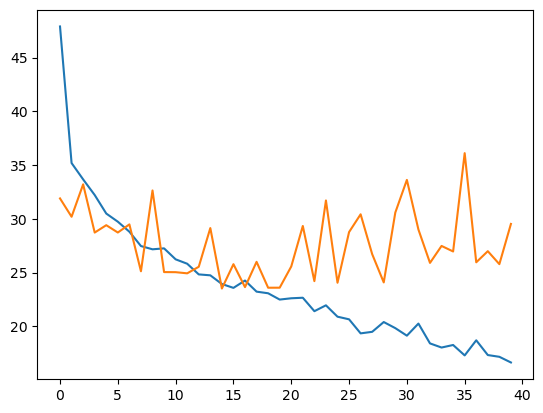

In [32]:
model = Sequential()
model.add(LSTM(units = 256, return_sequences = True))

model.add(LSTM(units = 256, return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 256, return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 256, return_sequences = True))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train_s, y_train_s, epochs = 40, batch_size = 32, validation_data=(X_test_s, y_test_s), workers=8)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
y_pred_lstm = model.predict(X_test_s)
codebase.metrics(y_test, y_pred_lstm.reshape((X_test.shape[0],)))

## 64/128 128/64

Epoch 1/9
458/458 [==============================] - 5s 5ms/step - loss: 47.3355 - val_loss: 31.9875
Epoch 2/9
458/458 [==============================] - 2s 5ms/step - loss: 34.2594 - val_loss: 29.4745
Epoch 3/9
458/458 [==============================] - 2s 4ms/step - loss: 32.0429 - val_loss: 32.6632
Epoch 4/9
458/458 [==============================] - 2s 5ms/step - loss: 30.6644 - val_loss: 27.9718
Epoch 5/9
458/458 [==============================] - 2s 4ms/step - loss: 29.4492 - val_loss: 26.3312
Epoch 6/9
458/458 [==============================] - 2s 4ms/step - loss: 28.9803 - val_loss: 30.6056
Epoch 7/9
458/458 [==============================] - 2s 4ms/step - loss: 27.2572 - val_loss: 28.1803
Epoch 8/9
458/458 [==============================] - 2s 4ms/step - loss: 26.4296 - val_loss: 26.5136
Epoch 9/9
458/458 [==============================] - 2s 4ms/step - loss: 25.7295 - val_loss: 28.3627
MSE  : 28.3627058330489
RMSE : 5.32566482545127


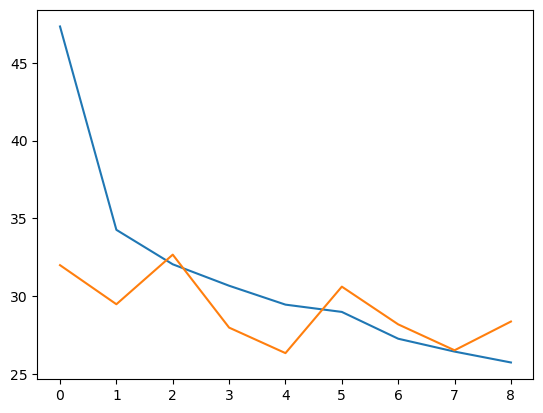

In [ ]:
model = Sequential()
model.add(LSTM(units = 64, return_sequences = True))

model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 128))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train_s, y_train_s, epochs = 8, batch_size = 20, validation_data=(X_test_s, y_test_s))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
y_pred_lstm = model.predict(X_test_s)
codebase.metrics(y_test, y_pred_lstm.reshape((X_test.shape[0],)))

Epoch 1/20
458/458 [==============================] - 6s 5ms/step - loss: 49.0815 - val_loss: 31.7120
Epoch 2/20
458/458 [==============================] - 2s 4ms/step - loss: 35.6075 - val_loss: 29.6184
Epoch 3/20
458/458 [==============================] - 2s 4ms/step - loss: 33.7663 - val_loss: 28.6893
Epoch 4/20
458/458 [==============================] - 2s 4ms/step - loss: 31.4930 - val_loss: 28.4866
Epoch 5/20
458/458 [==============================] - 2s 4ms/step - loss: 30.2990 - val_loss: 27.5319
Epoch 6/20
458/458 [==============================] - 2s 4ms/step - loss: 29.3969 - val_loss: 26.9133
Epoch 7/20
458/458 [==============================] - 2s 4ms/step - loss: 28.2422 - val_loss: 27.1360
Epoch 8/20
458/458 [==============================] - 2s 4ms/step - loss: 27.4552 - val_loss: 26.0003
Epoch 9/20
458/458 [==============================] - 2s 4ms/step - loss: 26.7755 - val_loss: 30.2209
Epoch 10/20
458/458 [==============================] - 2s 4ms/step - loss: 26.3161

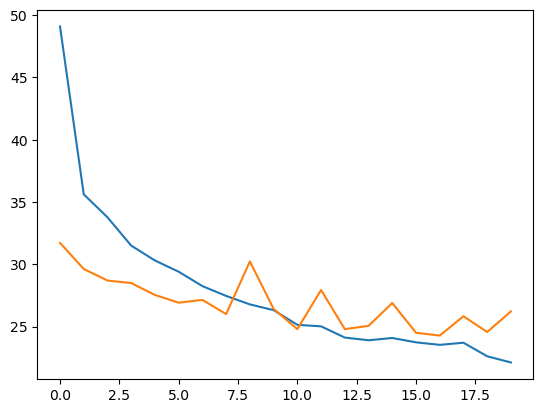

In [20]:
model = Sequential()
model.add(LSTM(units = 128, return_sequences = True))

model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 128))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train_s, y_train_s, epochs = 20, batch_size = 20, validation_data=(X_test_s, y_test_s))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
y_pred_lstm = model.predict(X_test_s)
codebase.metrics(y_test, y_pred_lstm.reshape((X_test.shape[0],)))

Epoch 1/20
458/458 [==============================] - 5s 4ms/step - loss: 53.6353 - val_loss: 35.2185
Epoch 2/20
458/458 [==============================] - 2s 4ms/step - loss: 36.9806 - val_loss: 32.6528
Epoch 3/20
458/458 [==============================] - 2s 4ms/step - loss: 33.8396 - val_loss: 29.6466
Epoch 4/20
458/458 [==============================] - 2s 5ms/step - loss: 32.1420 - val_loss: 31.1359
Epoch 5/20
458/458 [==============================] - 2s 4ms/step - loss: 30.9997 - val_loss: 31.0288
Epoch 6/20
458/458 [==============================] - 2s 4ms/step - loss: 29.7696 - val_loss: 29.6291
Epoch 7/20
458/458 [==============================] - 2s 4ms/step - loss: 29.0529 - val_loss: 35.9902
Epoch 8/20
458/458 [==============================] - 2s 4ms/step - loss: 28.0544 - val_loss: 27.8761
Epoch 9/20
458/458 [==============================] - 2s 5ms/step - loss: 27.1874 - val_loss: 24.9624
Epoch 10/20
458/458 [==============================] - 2s 4ms/step - loss: 26.5717

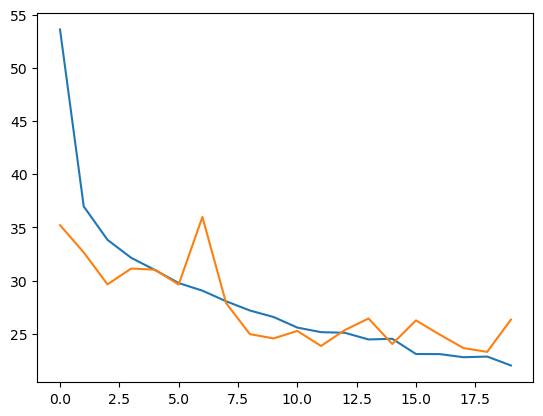

In [22]:
model = Sequential()
model.add(LSTM(units = 64, return_sequences = True))

model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 64))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train_s, y_train_s, epochs = 20, batch_size = 20, validation_data=(X_test_s, y_test_s))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
y_pred_lstm = model.predict(X_test_s)
codebase.metrics(y_test, y_pred_lstm.reshape((X_test.shape[0],)))

# Ensemble

Testing multiple ensemble model

In [171]:
np.c_[y_pred_svr200, y_pred_lstm.reshape((y_pred_lstm.shape[0],))]

array([[ 3.64098772e-01,  4.28641021e-01],
       [ 1.65448606e-01,  8.13345850e-01],
       [ 2.63724084e+00,  2.60359621e+00],
       ...,
       [ 2.39581861e+00,  9.70852375e-03],
       [ 2.59915891e+00, -4.91904676e-01],
       [ 9.07463470e-04,  2.80837774e-01]])

In [104]:
y_pred_combo = np.mean(np.c_[y_pred_svr100, y_pred_xgb], axis=1)
codebase.metrics(y_test, y_pred_combo)

MSE  : 22.116798648287492
RMSE : 4.702850055900942


In [105]:
y_pred_combo = np.mean(np.c_[y_pred_svr100, y_pred_lstm.reshape((y_pred_lstm.shape[0],))], axis=1)
codebase.metrics(y_test, y_pred_combo)

MSE  : 23.470849623734335
RMSE : 4.8446722927081804


In [106]:
y_pred_combo = np.mean(np.c_[y_pred_xgb, y_pred_lstm.reshape((y_pred_lstm.shape[0],))], axis=1)
codebase.metrics(y_test, y_pred_combo)

MSE  : 22.732152107271204
RMSE : 4.767824672455061


In [107]:
y_pred_combo = np.mean(np.c_[y_pred_svr100, y_pred_xgb, y_pred_lstm.reshape((y_pred_lstm.shape[0],))], axis=1)
codebase.metrics(y_test, y_pred_combo)

MSE  : 22.026029669083094
RMSE : 4.693189711601598


In [27]:
y_pred_combo = np.mean(np.c_[y_pred_svr200, y_pred_lstm.reshape((y_pred_lstm.shape[0],))], axis=1)
codebase.metrics(y_test, y_pred_combo)

MSE  : 23.098441909246723
RMSE : 4.806083843343426


In [108]:
y_pred_combo = np.mean(np.c_[y_pred_svr500, y_pred_xgb, y_pred_lstm.reshape((y_pred_lstm.shape[0],))], axis=1)
codebase.metrics(y_test, y_pred_combo)

MSE  : 21.31075951513679
RMSE : 4.616357819226841


In [52]:
y_pred_combo = np.mean(np.c_[y_pred_svr1000, y_pred_xgb, y_pred_lstm.reshape((y_pred_lstm.shape[0],))], axis=1)
codebase.metrics(y_test, y_pred_combo)

MSE  : 20.74121240865556
RMSE : 4.55425212396674


# Test prediction

In [82]:
df_test = pd.read_csv('test.csv')
df_test = codebase.missing_data_alpha3(df_test)
df_test

,id,time,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm),elevation,city
0,0,2021-08-02,32.3,25.3,38.2,29.6,2021-08-02T05:39,2021-08-02T17:30,20.79,0.00,7.6,16.9,134.0,4.45,0,su
1,1,2021-08-03,31.7,25.5,37.4,30.3,2021-08-03T05:39,2021-08-03T17:30,20.01,0.00,10.2,21.6,131.0,4.32,0,su
2,2,2021-08-04,32.6,25.7,37.1,30.8,2021-08-04T05:39,2021-08-04T17:30,20.89,0.00,17.3,32.4,116.0,4.73,0,su
3,3,2021-08-05,32.0,25.7,36.8,31.1,2021-08-05T05:39,2021-08-05T17:30,22.19,0.00,15.8,29.2,115.0,4.96,0,su
4,4,2021-08-06,31.9,26.3,36.0,31.6,2021-08-06T05:38,2021-08-06T17:30,21.84,0.00,20.2,36.7,106.0,4.99,0,su
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4967,4967,2022-12-18,-6.9,-13.1,-13.5,-19.5,1970-01-01T07:00,1970-01-01T07:00,0.00,1.12,21.7,31.7,47.0,0.48,0,q
4968,4968,2022-12-19,-2.5,-6.8,-7.1,-13.4,1970-01-01T07:00,1970-01-01T07:00,0.00,1.40,21.6,31.0,64.0,0.51,0,q
4969,4969,2022-12-20,-4.6,-16.9,-9.0,-21.9,1970-01-01T07:00,1970-01-01T07:00,0.00,1.05,14.1,23.0,273.0,0.03,0,q
4970,4970,2022-12-21,-17.2,-21.2,-22.2,-26.5,1970-01-01T07:00,1970-01-01T07:00,0.00,0.00,10.8,19.1,293.0,0.00,0,q


In [83]:
df_test_h_mean = pd.read_csv("test_hourly_mean.csv")
df_test_h_mean

,time,city,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,et0_fao_evapotranspiration (mm),vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2021-08-02,b,19.758333,84.750000,16.983333,21.091667,1014.216667,881.316667,0.000000,59.541667,...,0.135417,0.387917,20.608333,20.487500,20.400000,20.200000,0.355375,0.327583,0.336417,0.409958
1,2021-08-02,le,27.425000,84.541667,24.429167,33.145833,1011.500000,994.208333,0.000000,26.708333,...,0.168333,0.617083,23.825000,23.804167,23.604167,23.700000,0.402625,0.379458,0.375417,0.431000
2,2021-08-02,lh,26.262500,87.166667,23.858333,34.062500,1009.929167,1011.629167,0.000000,42.500000,...,0.175000,0.474167,26.845833,26.962500,27.000000,26.700000,0.413542,0.396958,0.388542,0.428542
3,2021-08-02,p,26.741667,86.750000,24.279167,31.645833,1010.679167,1010.179167,0.000000,38.625000,...,0.145833,0.483750,27.287500,26.920833,26.900000,26.900000,0.358792,0.352792,0.362042,0.389625
4,2021-08-02,sa,25.733333,81.875000,22.300000,29.408333,1007.170833,1002.929167,0.000000,48.208333,...,0.134167,0.643333,26.279167,25.137500,21.325000,14.191667,0.188417,0.171750,0.255000,0.375333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4967,2022-12-22,sa,-2.412500,85.458333,-4.558333,-5.220833,999.345833,994.729167,0.291667,66.791667,...,0.025833,0.078750,-0.758333,0.087500,2.920833,9.737500,0.386042,0.383167,0.396708,0.396000
4968,2022-12-22,si,26.475000,87.916667,24.241667,32.841667,1006.004167,982.970833,0.000000,87.583333,...,0.137917,0.438750,26.062500,26.454167,26.600000,26.300000,0.293792,0.274542,0.293875,0.304000
4969,2022-12-22,su,26.825000,84.666667,23.975000,32.308333,1005.320833,1007.620833,0.000000,69.958333,...,0.137083,0.557917,28.070833,28.637500,29.016667,28.900000,0.302458,0.304250,0.280875,0.299583
4970,2022-12-22,t,13.854167,90.333333,12.245833,15.441667,1013.016667,743.020833,0.000000,87.916667,...,0.125000,0.162500,16.800000,16.483333,16.237500,16.300000,0.335958,0.342583,0.336083,0.341000


In [84]:
df_test_h_median = pd.read_csv("test_hourly_median.csv")
df_test_h_median = df_test_h_median.loc[:, columns_sum_used + ["time", "city"]]
df_test_h_median

,shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),time,city
0,14.5,2.0,12.5,50.40,2021-08-02,b
1,18.5,10.5,8.0,0.00,2021-08-02,le
2,19.0,5.0,14.0,63.75,2021-08-02,lh
3,13.5,5.5,8.0,10.45,2021-08-02,p
4,62.5,17.0,45.5,88.55,2021-08-02,sa
...,...,...,...,...,...,...
4967,0.0,0.0,0.0,0.00,2022-12-22,sa
4968,27.5,1.0,21.5,0.45,2022-12-22,si
4969,18.5,1.5,16.5,1.25,2022-12-22,su
4970,17.0,4.0,13.0,35.45,2022-12-22,t


In [85]:
df_test_h_windir = pd.read_csv('test_hourly_winddir.csv')
df_test_h_windir

,time,city,winddirection_10m (°)_sin,winddirection_100m (°)_sin,winddirection_10m (°)_cos,winddirection_100m (°)_cos
0,2021-08-02,b,-0.781702,-0.811149,-0.623652,-0.584840
1,2021-08-02,le,0.463038,0.999941,-0.886338,0.010908
2,2021-08-02,lh,-0.451397,-0.467544,-0.892323,-0.883970
3,2021-08-02,p,-0.442289,-0.414031,-0.896873,-0.910263
4,2021-08-02,sa,0.698832,0.588373,-0.715286,-0.808589
...,...,...,...,...,...,...
4967,2022-12-22,sa,0.961662,0.912060,-0.274239,-0.410056
4968,2022-12-22,si,-0.601815,-0.641673,-0.798636,-0.766979
4969,2022-12-22,su,-0.994135,-0.996382,0.108144,0.084982
4970,2022-12-22,t,0.454638,-0.569399,-0.890676,-0.822061


In [86]:
test_h_mean_intersection = set(df_test.columns).union(set(df_test_h_median.columns)).union(set(df_test_h_windir.columns)).intersection(df_test_h_mean.columns).union({'winddirection_10m (°)', 'winddirection_100m (°)'})
test_h_mean_cols = df_test_h_mean.columns.difference(test_h_mean_intersection).union({'time', 'city'})
df_test_h_mean = df_test_h_mean.loc[:, test_h_mean_cols]

## Preprocessing

In [87]:
df_merged = df_test.merge(df_test_h_mean, left_on=['time', 'city'], right_on=['time', 'city'], how='inner'
                    ).merge(df_test_h_median, left_on=['time', 'city'], right_on=['time', 'city'], how='inner'
                    ).merge(df_test_h_windir, left_on=['time', 'city'], right_on=['time', 'city'], how='inner')

In [88]:
df_merged

# df_merged = df_merged.drop('winddirection_10m_dominant (°)', axis=1)

,id,time,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),...,windspeed_100m (km/h),windspeed_10m (km/h),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),winddirection_10m (°)_sin,winddirection_100m (°)_sin,winddirection_10m (°)_cos,winddirection_100m (°)_cos
0,0,2021-08-02,32.3,25.3,38.2,29.6,2021-08-02T05:39,2021-08-02T17:30,20.79,0.00,...,6.875000,4.633333,6.0,1.5,4.5,34.95,0.686770,0.705562,-0.726874,-0.708648
1,1,2021-08-03,31.7,25.5,37.4,30.3,2021-08-03T05:39,2021-08-03T17:30,20.01,0.00,...,8.579167,6.025000,6.5,2.5,4.0,35.70,0.471397,0.498740,-0.881921,-0.866752
2,2,2021-08-04,32.6,25.7,37.1,30.8,2021-08-04T05:39,2021-08-04T17:30,20.89,0.00,...,13.325000,9.112500,6.5,2.5,4.0,53.30,0.716302,0.755663,-0.697790,-0.654961
3,3,2021-08-05,32.0,25.7,36.8,31.1,2021-08-05T05:39,2021-08-05T17:30,22.19,0.00,...,13.025000,8.612500,7.0,2.5,4.5,54.60,0.711209,0.778060,-0.702981,-0.628189
4,4,2021-08-06,31.9,26.3,36.0,31.6,2021-08-06T05:38,2021-08-06T17:30,21.84,0.00,...,16.391667,10.966667,7.5,2.5,5.0,53.40,0.876377,0.925265,-0.481626,-0.379322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4967,4967,2022-12-18,-6.9,-13.1,-13.5,-19.5,1970-01-01T07:00,1970-01-01T07:00,0.00,1.12,...,26.025000,19.050000,0.0,0.0,0.0,0.00,0.724372,0.799510,0.689409,0.600653
4968,4968,2022-12-19,-2.5,-6.8,-7.1,-13.4,1970-01-01T07:00,1970-01-01T07:00,0.00,1.40,...,24.550000,18.512500,0.0,0.0,0.0,0.00,0.945991,0.999465,0.324193,-0.032719
4969,4969,2022-12-20,-4.6,-16.9,-9.0,-21.9,1970-01-01T07:00,1970-01-01T07:00,0.00,1.05,...,10.383333,9.216667,0.0,0.0,0.0,0.00,-0.999365,-0.903522,0.035626,-0.428541
4970,4970,2022-12-21,-17.2,-21.2,-22.2,-26.5,1970-01-01T07:00,1970-01-01T07:00,0.00,0.00,...,9.391667,9.154167,0.0,0.0,0.0,0.00,-0.920789,-0.918216,0.390062,0.396080


In [89]:
id_number = df_merged.id.copy()
id_number

0          0
1          1
2          2
3          3
4          4
        ... 
4967    4967
4968    4968
4969    4969
4970    4970
4971    4971
Name: id, Length: 4972, dtype: int64

In [90]:
df_merged = codebase.preprocessing_alpha5(data=df_merged)
df_merged = feature_eng(df_merged)
df_merged = df_merged.drop('id', axis=1)

df_merged

,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm),...,city_6,city_7,city_8,city_9,combo1,combo2,humidxdew,windrxhumid,windrxdew,combo3
time,,,,,,,,,,,,,,,,,,,,,
2021-08-02,32.3,25.3,38.2,29.6,20.79,0.00,7.6,16.9,134.0,4.45,...,0.0,1.0,0.0,0.0,605.506944,1354.815000,1341.618750,-32.530929,-10.277194,16.568625
2021-08-03,31.7,25.5,37.4,30.3,20.01,0.00,10.2,21.6,131.0,4.32,...,0.0,1.0,0.0,0.0,1328.250000,1380.690000,1486.950000,-28.685702,-8.959085,16.824500
2021-08-04,32.6,25.7,37.1,30.8,20.89,0.00,17.3,32.4,116.0,4.73,...,0.0,1.0,0.0,0.0,458.461806,1464.040833,1524.020486,-35.029659,-10.869191,16.691514
2021-08-05,32.0,25.7,36.8,31.1,22.19,0.00,15.8,29.2,115.0,4.96,...,0.0,1.0,0.0,0.0,364.250000,1564.395000,1507.231250,-35.247614,-10.688860,18.559125
2021-08-06,31.9,26.3,36.0,31.6,21.84,0.00,20.2,36.7,106.0,4.99,...,0.0,1.0,0.0,0.0,161.156250,1564.290000,1547.398438,-30.231911,-9.118817,20.681719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-18,-6.9,-13.1,-13.5,-19.5,0.00,1.12,21.7,31.7,47.0,0.48,...,0.0,0.0,0.0,0.0,5457.776042,0.000000,-1117.620833,27.403959,-10.170885,0.000000
2022-12-19,-2.5,-6.8,-7.1,-13.4,0.00,1.40,21.6,31.0,64.0,0.51,...,0.0,0.0,0.0,0.0,6033.062500,0.000000,-833.371875,19.091037,-4.105723,0.000000
2022-12-20,-4.6,-16.9,-9.0,-21.9,0.00,1.05,14.1,23.0,273.0,0.03,...,0.0,0.0,0.0,0.0,1310.111111,0.000000,-1330.266667,-2.691042,0.626624,0.000000


In [91]:
df_merged.columns

Index(['temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'apparent_temperature_max (°C)', 'apparent_temperature_min (°C)',
       'shortwave_radiation_sum (MJ/m²)', 'snowfall_sum (cm)',
       'windspeed_10m_max (km/h)', 'windgusts_10m_max (km/h)',
       'winddirection_10m_dominant (°)', 'et0_fao_evapotranspiration (mm)',
       'apparent_temperature (°C)', 'cloudcover (%)', 'cloudcover_high (%)',
       'cloudcover_low (%)', 'cloudcover_mid (%)', 'dewpoint_2m (°C)',
       'pressure_msl (hPa)', 'relativehumidity_2m (%)', 'snowfall (cm)',
       'soil_moisture_0_to_7cm (m³/m³)', 'soil_moisture_100_to_255cm (m³/m³)',
       'soil_moisture_28_to_100cm (m³/m³)', 'soil_moisture_7_to_28cm (m³/m³)',
       'soil_temperature_0_to_7cm (°C)', 'soil_temperature_100_to_255cm (°C)',
       'soil_temperature_28_to_100cm (°C)', 'soil_temperature_7_to_28cm (°C)',
       'surface_pressure (hPa)', 'temperature_2m (°C)',
       'vapor_pressure_deficit (kPa)', 'windgusts_10m (km/h)',
       '

In [92]:
df_scaled = ss.transform(df_merged)
df_scaled.shape

(4972, 63)

## Prediction

In [43]:
# svr = SVR(C=100, degree=1, gamma=0.01)
# svr.fit(X, y)
# y_pred_svr100 = svr.predict(df_scaled)

In [44]:
# svr = SVR(C=500, degree=1, gamma=0.01)
# svr.fit(X, y)
# y_pred_svr500 = svr.predict(df_scaled)

In [94]:
svr = SVR(C=1000, degree=1, gamma=0.01)
svr.fit(X, y)
y_pred_svr1000 = svr.predict(df_scaled)
y_pred_svr1000

array([0.41340442, 0.5301491 , 0.14994552, ..., 1.45305294, 2.01761474,
       0.73911326])

In [95]:
bst = XGBRegressor()
bst.fit(X, y)
y_pred_xgb = bst.predict(df_scaled)
y_pred_xgb

array([-0.09932651,  0.6640013 ,  0.09227505, ..., -0.40534315,
       -0.35226625, -0.38399735], dtype=float32)

In [96]:
X_s = X.reshape((X.shape[0], 1, X.shape[1]))
y_s = np.array(y)
df_scaled_s = df_scaled.reshape((df_scaled.shape[0], 1, df_scaled.shape[1]))

In [97]:
model = Sequential()
model.add(LSTM(units = 100, return_sequences = True))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_s, y_s, epochs = 16, batch_size = 20)

Epoch 1/16
655/655 [==============================] - 4s 3ms/step - loss: 45.5627
Epoch 2/16
655/655 [==============================] - 2s 2ms/step - loss: 33.4367
Epoch 3/16
655/655 [==============================] - 2s 2ms/step - loss: 30.6520
Epoch 4/16
655/655 [==============================] - 2s 2ms/step - loss: 29.0135
Epoch 5/16
655/655 [==============================] - 2s 2ms/step - loss: 27.6662
Epoch 6/16
655/655 [==============================] - 2s 2ms/step - loss: 26.4585
Epoch 7/16
655/655 [==============================] - 2s 2ms/step - loss: 25.9725
Epoch 8/16
655/655 [==============================] - 2s 2ms/step - loss: 25.4202
Epoch 9/16
655/655 [==============================] - 2s 2ms/step - loss: 24.5405
Epoch 10/16
655/655 [==============================] - 2s 2ms/step - loss: 24.1970
Epoch 11/16
655/655 [==============================] - 2s 2ms/step - loss: 23.6932
Epoch 12/16
655/655 [==============================] - 2s 2ms/step - loss: 23.2030
Epoch 13/16
6

In [98]:
y_pred_lstm = model.predict(df_scaled_s)
y_pred_lstm 

array([[[0.2635749 ]],

       [[0.40060282]],

       [[0.4114325 ]],

       ...,

       [[0.3155229 ]],

       [[0.29626733]],

       [[0.2291761 ]]], dtype=float32)

In [99]:
y_pred_combo = np.mean(np.c_[y_pred_svr1000, y_pred_xgb, y_pred_lstm.reshape((y_pred_lstm.shape[0],))], axis=1)

In [100]:
submission = y_pred_combo

In [101]:
submission

array([0.19255094, 0.5315844 , 0.21788436, ..., 0.4544109 , 0.65387194,
       0.19476401])

In [102]:
pd.Series(submission)

0       0.192551
1       0.531584
2       0.217884
3       0.202222
4       0.228240
          ...   
4967    0.358438
4968    0.458711
4969    0.454411
4970    0.653872
4971    0.194764
Length: 4972, dtype: float64

In [103]:
jan_21_1 = pd.DataFrame({'id':id_number, 'rain_sum (mm)':submission}).set_index('id')
jan_21_1

,rain_sum (mm)
id,
0,0.192551
1,0.531584
2,0.217884
3,0.202222
4,0.228240
...,...
4967,0.358438
4968,0.458711
4969,0.454411


## Jan 21

Test results

In [104]:
jan_21_1.to_csv('jan_21_1.csv')